# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [126]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
from matplotlib import cm
from PIL import Image
import pandas as pd
%matplotlib inline

In [127]:
train_set = get_dataset("/home/workspace/data/train/*.tfrecord")
test_set = get_dataset("/home/workspace/data/test/*.tfrecord")
val_set = get_dataset("/home/workspace/data/val/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/test/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/test/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 3
INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/val/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/val/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 10


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [128]:
def display_images10(batch):
    # TODO - Your implementation here
    colors = {1:[1,0,0], 2: [0,1,0], 4: [0,0,1]}
    
    fig, ax = plt.subplots(2,5,figsize=(20,10))
    for idx, datapoint in enumerate(batch):
        
        x = idx % 2
        y = idx % 5
        w, h, c = datapoint["image"].shape
        ax[x,y].imshow(datapoint["image"].numpy().astype("uint8"))
        groundtruth_classes = datapoint["groundtruth_classes"].numpy()
        for i in range(len(datapoint["groundtruth_boxes"])):
            ymin, xmin, ymax, xmax = datapoint["groundtruth_boxes"][i]
            ground_class = groundtruth_classes[i]
            rect = patches.Rectangle((xmin*w, ymin*h), (xmax-xmin)*w, (ymax-ymin)*h, edgecolor=colors[ground_class], facecolor="none")
            ax[x,y].add_patch(rect)
        ax[x,y].axis('off')
    print("The shape of the image width*height*channel:",w,h,c)
    plt.tight_layout()
    plt.show() 

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

In [129]:
# create a batch of images from training dataset
list_datapoint = []
for datapoint in train_set.shuffle(10).take(10):
    list_datapoint.append(datapoint)

The shape of the image width*height*channel: 640 640 3


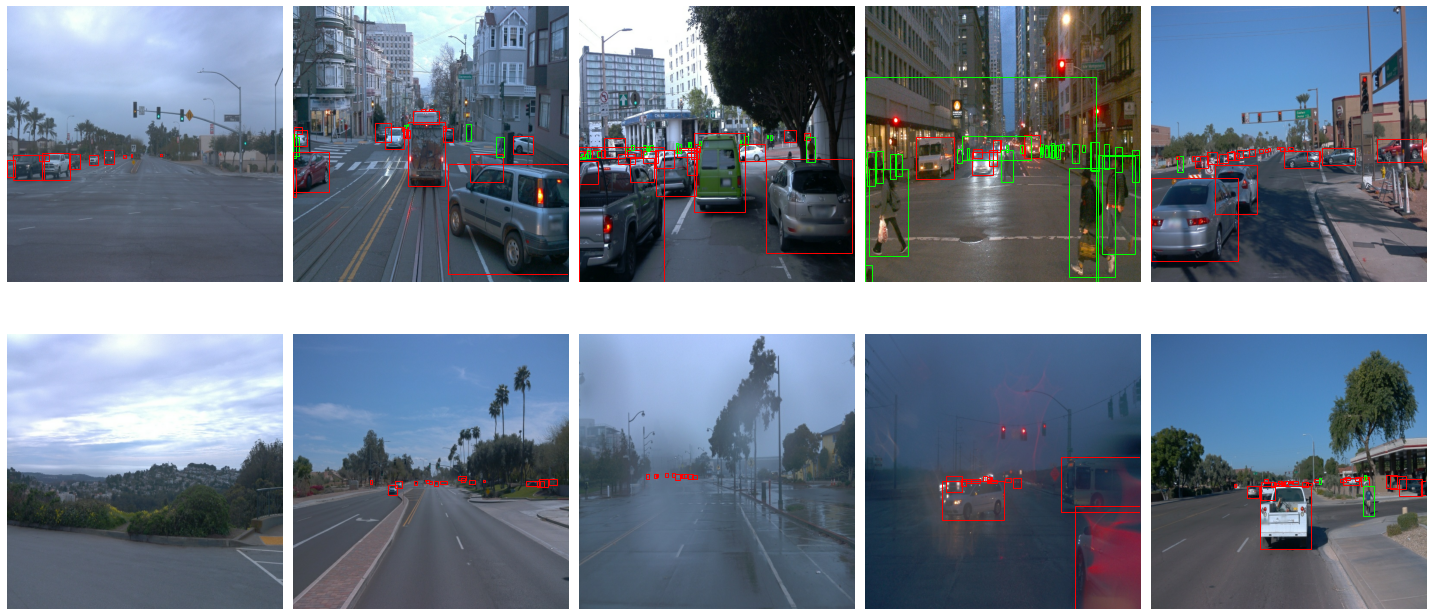

In [130]:
# Display the batch of images from the training set with their asssciated bounding boxes
display_images10(list_datapoint)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

### 1. Class Distribution in the dataset:

In [131]:
def get_class_freq(train_set, num_datapoints):
    class_freq = {}
    for datapoint in train_set.take(num_datapoints):
        
        for i in range(len(datapoint["groundtruth_classes"])):
            groundtruth_classes = datapoint["groundtruth_classes"].numpy()
            groundtruth_boxes = datapoint["groundtruth_boxes"].numpy()
            
            if groundtruth_classes[i] in class_freq.keys():
                class_freq[groundtruth_classes[i]] += 1
            else:
                class_freq[groundtruth_classes[i]] = 1
    return class_freq

In [132]:
# Frequency of each class in the training set
class_freq = get_class_freq(train_set, 2000)

In [133]:
print(class_freq)

{1: 34222, 2: 9512, 4: 227}


Text(0, 0.5, 'CLASS_FREQUENCIES')

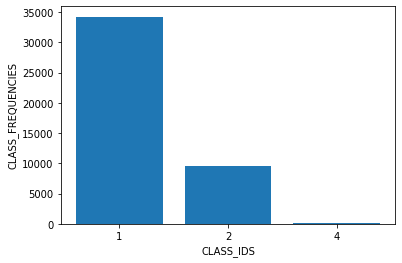

In [134]:
# plot the class frequencies as a bar plot
# from the plot we can conclude that there is very high class imabalance data
fig = plt.figure()
cls_ids = [str(cls_id) for cls_id in class_freq.keys()]
plt.bar(cls_ids, list(class_freq.values()))
plt.xlabel("CLASS_IDS")
plt.ylabel("CLASS_FREQUENCIES")

###  2. Number of objects per frame:

In [135]:
# number of objects in each frame
def get_objects(train_set, num_datapoints):
    """get number of objects per frame and save as a dtaframe"""
    freq_list = []
    for datapoint in train_set.take(num_datapoints):
        temp = {}
        for i in range(len(datapoint["groundtruth_classes"])):
            groundtruth_classes = datapoint["groundtruth_classes"].numpy()
            groundtruth_boxes = datapoint["groundtruth_boxes"].numpy()
            
            if groundtruth_classes[i] in temp.keys():
                temp[groundtruth_classes[i]] += 1
            else:
                temp[groundtruth_classes[i]] = 1
        freq_list.append(temp)
    df  = pd.DataFrame(freq_list)
    return df

In [136]:
df = get_objects(train_set,2000)

In [137]:
def count_objects(df):
    """Count number of objects class wise per frame in the given set of datapoints."""
    object_count = {}
    for i in df.columns:
        
        count = df[i].sum().sum() / df.shape[0]
        object_count[i] = count
    # average number of objects per frame
    count = df.sum(axis = 1).sum() / df.shape[0]
    object_count["average"] = count
    return object_count   

In [138]:
object_count = count_objects(df)

Text(0, 0.5, 'Average Objects per FRAME')

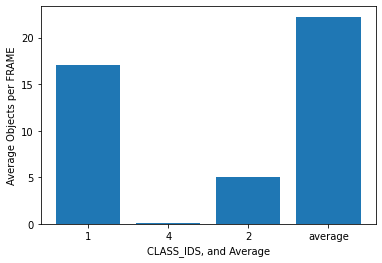

In [139]:
plt.bar(range(len(list(object_count.values()))), list(object_count.values()), tick_label=list(object_count.keys()))
plt.xlabel("CLASS_IDS, and Average")
plt.ylabel("Average Objects per FRAME")